## Setup

## Import Libraries

In [5]:
import os
import glob
import re
import json
import time
import pandas as pd
import copy
import collections

## Import Gemini

In [6]:
from kaggle_secrets import UserSecretsClient
import google.generativeai as genai

# Load API key securely
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("GOOGLE_API_KEY")

# Configure Gemini
genai.configure(api_key=api_key)

# Set up Gemini Pro model
model = genai.GenerativeModel("models/gemini-2.0-flash")

## Import the Sagas Dataset
This dataset is from https://sagadb.org/ - format Text (UTF-8). For the current use case only the english translations of sagas (18) were included.

Sagas included:
- bandamanna_saga
- brennu-njals_saga
- egils_saga
- eiriks_saga_rauda
- eyrbyggja_saga
- faereyinga_saga
- gisla_saga_surssonar
- grettis_saga
- gunnlaugs_saga_ormstungu
- haensna-thoris_saga
- havardar_saga_isfirdings
- heidarviga_saga
- heidarviga_saga
- hrafnkels_saga_freysgoda
- kormaks_saga
- laxdaela_saga
- thordar_saga_hredu
- viga-glums_saga
- viglundar_saga

In [7]:
# Path to sagas dataset
SAGAS_PATH = "/kaggle/input/sagas-en/sagas_en"

# List all .txt files (sagas)
saga_files = sorted(glob.glob(f"{SAGAS_PATH}/*.txt"))
print(f"Found {len(saga_files)} saga files.")
print("\nExample file:", saga_files[0])

Found 18 saga files.

Example file: /kaggle/input/sagas-en/sagas_en/bandamanna_saga.en.txt


In [8]:
import pandas as pd
import os
import re

# Build inventory of sagas
saga_inventory = []

for filepath in saga_files:
    filename = os.path.basename(filepath)  # e.g., "bandamanna_saga.en.txt"
    
    # Extract parts
    name_part, lang_part, _ = filename.split(".")  # ["bandamanna_saga", "en", "txt"]
    
    # Clean name: replace underscores with spaces and capitalize each word
    clean_name = re.sub(r"_", " ", name_part).title()
    
    saga_inventory.append({
        "Clean Name": clean_name,
        "Language": lang_part,
        "Filename": filename
    })

# Convert to DataFrame
saga_df = pd.DataFrame(saga_inventory)

# Display the table
display(saga_df)

# Print total count
print(f"Total sagas found: {len(saga_df)}")


,Clean Name,Language,Filename
0,Bandamanna Saga,en,bandamanna_saga.en.txt
1,Brennu-Njals Saga,en,brennu-njals_saga.en.txt
2,Egils Saga,en,egils_saga.en.txt
3,Eiriks Saga Rauda,en,eiriks_saga_rauda.en.txt
4,Eyrbyggja Saga,en,eyrbyggja_saga.en.txt
5,Faereyinga Saga,en,faereyinga_saga.en.txt
6,Gisla Saga Surssonar,en,gisla_saga_surssonar.en.txt
7,Grettis Saga,en,grettis_saga.en.txt
8,Gunnlaugs Saga Ormstungu,en,gunnlaugs_saga_ormstungu.en.txt
9,Haensna-Thoris Saga,en,haensna-thoris_saga.en.txt


Total sagas found: 18


### Splitting the Sagas into Chapters for smaller chunks

In [9]:
def split_into_chapters(text):
    # Normalize line breaks
    text = text.replace('\r\n', '\n')

    # Match common chapter formats (case-insensitive)
    chapter_splits = re.split(r"(?:^|\n)(CHAPTER\s+\w+|Chapter\s+\d+|CHAP\.\s*\w+)(?=\s|\n)", text, flags=re.IGNORECASE)

    if len(chapter_splits) < 3:
        # Fallback: split by double newlines
        chunks = re.split(r'\n{2,}', text)
        return [{"chapter": f"Chunk {i+1}", "text": chunk.strip()} for i, chunk in enumerate(chunks) if chunk.strip()]

    chapters = []
    for i in range(1, len(chapter_splits), 2):
        heading = chapter_splits[i].strip()
        body = chapter_splits[i+1].strip()
        if body:
            chapters.append({"chapter": heading, "text": body})
    return chapters


In [10]:
all_chapters = []

for path in saga_files:
    saga_name = os.path.basename(path).replace(".en.txt", "").replace("_", " ").title()
    
    try:
        with open(path, "r", encoding="utf-8") as f:
            text = f.read()
    except UnicodeDecodeError:
        print(f"⚠️ Skipping {saga_name} due to encoding issue.")
        continue

    chapters = split_into_chapters(text)
    for c in chapters:
        all_chapters.append({
            "saga": saga_name,
            "chapter": c["chapter"],
            "text": c["text"]
        })

print(f"✅ Extracted {len(all_chapters)} chapters from {len(saga_files)} sagas.")
print("📘 Example:", all_chapters[0]["saga"], "-", all_chapters[0]["chapter"])
print(all_chapters[0]["text"][:500])

✅ Extracted 790 chapters from 18 sagas.
📘 Example: Bandamanna Saga - Chapter 1
- Of Ufeig and Odd his son.

A man named Ufeig dwelt westaway in Midfirth, at a stead called Reeks: he was the son of Skidi, and his mother was called Gunnlaug, whose mother was Jarngerd, daughter of Ufeig Jarngerdson, of the Skards in the north country. Ufeig was wedded to a woman called Thorgerdi daughter of Vali; she came of great kin, and was a stirring woman. Ufeig was a wise man, and full of good counsel; he was great-hearted in all wise, but unhandy at money-getting; great and wide lands 


,Saga,Chapter Count
1,Brennu-Njals Saga,158
7,Grettis Saga,95
2,Egils Saga,92
14,Laxdaela Saga,78
4,Eyrbyggja Saga,65
5,Faereyinga Saga,58
16,Viga-Glums Saga,28
13,Kormaks Saga,27
11,Heidarviga Saga,26
10,Havardar Saga Isfirdings,24


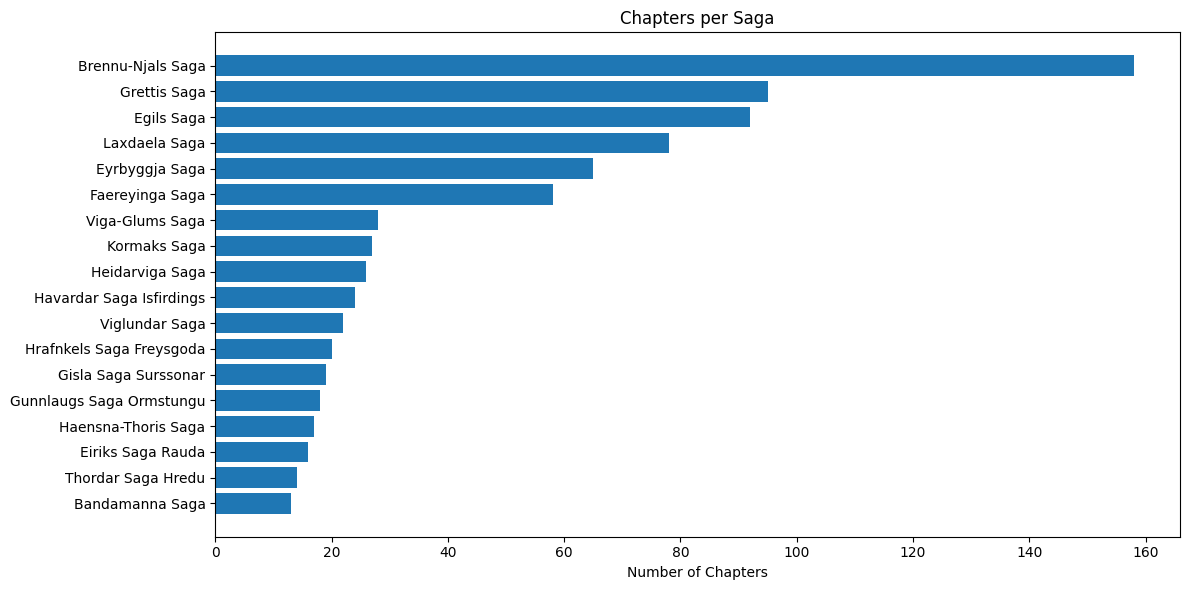

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert all_chapters to a DataFrame
chapters_df = pd.DataFrame(all_chapters)

# Count chapters per saga
chapter_counts = chapters_df.groupby("saga").size().reset_index(name="Chapter Count")
chapter_counts = chapter_counts.rename(columns={"saga": "Saga"})

# Sort by number of chapters (descending)
chapter_counts = chapter_counts.sort_values(by="Chapter Count", ascending=False)

# Display the table
display(chapter_counts)

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.barh(chapter_counts["Saga"], chapter_counts["Chapter Count"])
plt.xlabel("Number of Chapters")
plt.title("Chapters per Saga")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [12]:
CHUNK_SIZE = 6000  # or whatever you're using

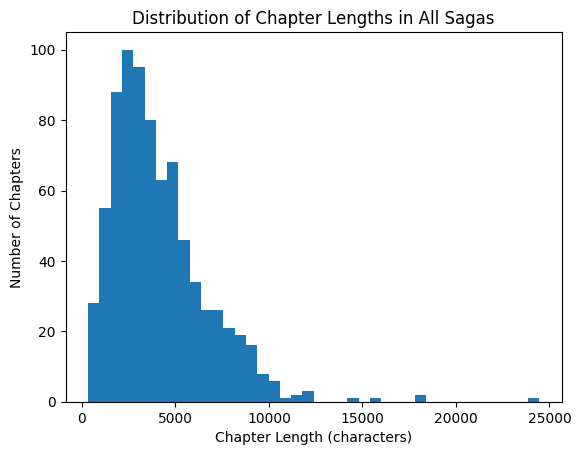

🔢 Max length: 24445
🔢 Median length: 3593
🔢 75th percentile: 5285


In [13]:
import matplotlib.pyplot as plt

chapter_lengths = [len(ch["text"]) for ch in all_chapters]

plt.hist(chapter_lengths, bins=40)
plt.xlabel("Chapter Length (characters)")
plt.ylabel("Number of Chapters")
plt.title("Distribution of Chapter Lengths in All Sagas")
plt.show()

print("🔢 Max length:", max(chapter_lengths))
print("🔢 Median length:", int(pd.Series(chapter_lengths).median()))
print("🔢 75th percentile:", int(pd.Series(chapter_lengths).quantile(0.75)))

In [14]:
def split_chapter_into_chunks(text, max_chars=CHUNK_SIZE):
    # Split by paragraphs and group until near max_chars
    paragraphs = text.split("\n\n")
    chunks = []
    current = ""

    for para in paragraphs:
        if len(current) + len(para) < max_chars:
            current += "\n\n" + para
        else:
            chunks.append(current.strip())
            current = para
    if current:
        chunks.append(current.strip())

    return chunks


In [15]:
chunk_counts = []

for chapter in all_chapters:
    chunks = split_chapter_into_chunks(chapter["text"], max_chars=CHUNK_SIZE)
    chunk_counts.append(len(chunks))

total_chunks = sum(chunk_counts)
print(f"📦 Total chunks across {len(all_chapters)} chapters: {total_chunks}")


📦 Total chunks across 790 chapters: 957


,Saga,Chunk Count
1,Brennu-Njals Saga,196
7,Grettis Saga,115
2,Egils Saga,111
14,Laxdaela Saga,97
4,Eyrbyggja Saga,74
5,Faereyinga Saga,60
16,Viga-Glums Saga,37
6,Gisla Saga Surssonar,36
13,Kormaks Saga,31
10,Havardar Saga Isfirdings,29


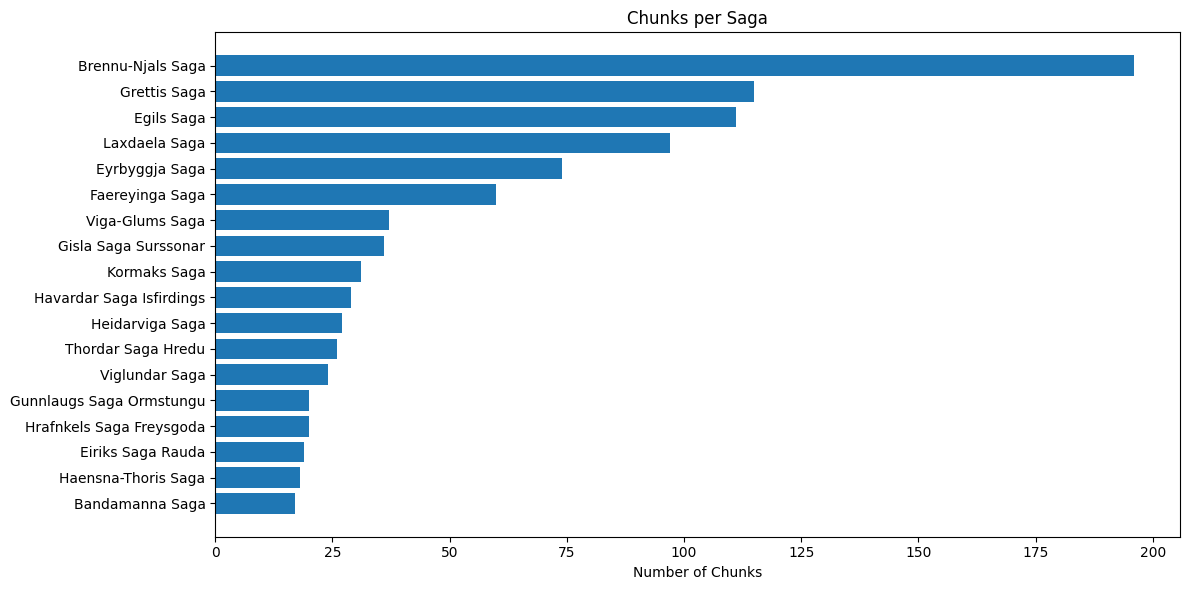

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Attach chunk counts to corresponding chapter entries
for i, chapter in enumerate(all_chapters):
    chapter["chunk_count"] = chunk_counts[i]

# Convert to DataFrame
chunks_df = pd.DataFrame(all_chapters)

# Group by saga to get total chunks per saga
chunk_counts_df = chunks_df.groupby("saga")["chunk_count"].sum().reset_index()
chunk_counts_df = chunk_counts_df.rename(columns={"saga": "Saga", "chunk_count": "Chunk Count"})

# Sort by chunk count descending
chunk_counts_df = chunk_counts_df.sort_values(by="Chunk Count", ascending=False)

# Display the table
display(chunk_counts_df)

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.barh(chunk_counts_df["Saga"], chunk_counts_df["Chunk Count"])
plt.xlabel("Number of Chunks")
plt.title("Chunks per Saga")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Get Characters in Chunk with Gen AI

In [17]:
import json

def build_character_extraction_prompt(chapter_text, saga_name, chapter_title, max_chars):
    example_texts_outputs = [
        {
            "text": """Example 1:
A man named Ufeig dwelt westaway in Midfirth, at a stead called Reeks: he was the son of Skidi, and his mother was called Gunnlaug, whose mother was Jarngerd, daughter of Ufeig Jarngerdson. Ufeig was wedded to a woman called Thorgerdi daughter of Vali. Ufeig had a son by his wife named Odd. One named Vali also grew up in Ufeig's house. Ufeig was thingman of Styrmir.""",
            "output": {
                "characters": [
                    {
                        "first_name": "Ufeig",
                        "patronym": "Skidison",
                        "gender": "male",
                        "nicknames": [],
                        "dwelling": ["Reeks", "Midfirth"],
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "husband", "with": "Thorgerdi" },
                            { "type": "father", "with": "Odd" },
                            { "type": "son", "with": "Skidi" },
                            { "type": "mother", "with": "Gunnlaug" },
                            { "type": "thingman of", "with": "Styrmir" }
                        ]
                    },
                    {
                        "first_name": "Thorgerdi",
                        "patronym": "Validottir",
                        "gender": "female",
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "wife", "with": "Ufeig" },
                            { "type": "daughter", "with": "Vali" },
                            { "type": "mother", "with": "Odd" }
                        ]
                    },
                    {
                        "first_name": "Odd",
                        "patronym": "Ufeigson",
                        "gender": "male",
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "son", "with": "Ufeig" },
                            { "type": "son", "with": "Thorgerdi" }
                        ]
                    },
                    {
                        "first_name": "Vali",
                        "gender": "male",
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "father", "with": "Thorgerdi" },
                            { "type": "grew up in house of", "with": "Ufeig" }
                        ]
                    },
                    {
                        "first_name": "Skidi",
                        "gender": "male",
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "father", "with": "Ufeig" }
                        ]
                    },
                    {
                        "first_name": "Gunnlaug",
                        "gender": "female",
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "mother", "with": "Ufeig" },
                            { "type": "daughter", "with": "Jarngerd" }
                        ]
                    },
                    {
                        "first_name": "Jarngerd",
                        "gender": "female",
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "mother", "with": "Gunnlaug" },
                            { "type": "daughter", "with": "Ufeig Jarngerdson" }
                        ]
                    },
                    {
                        "first_name": "Ufeig Jarngerdson",
                        "gender": "male",
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "father", "with": "Jarngerd" }
                        ]
                    },
                    {
                        "first_name": "Styrmir",
                        "gender": "male",
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "chieftain of", "with": "Ufeig" }
                        ]
                    }
                ]
            }
        },
        {
            "text": """Example 2:
All this while nought had been heard of Uspak: a man named Mar married Swala; he was the son of Hildi; he took up his abode at Swalastead; a brother he had named Bialfi, half-witted, but a strong man. There was one named Bergthor, who dwelt at Bodvarsknolls: he had summed up the case when Uspak was outlawed; and so on an eve at Bodvarsknolls, when men were sitting by the fires, it fell out that one came and smote on the door and bade the master come out; but the master wotted that Uspak was come there, and said that he would nowise go out. Uspak egged him much thereto, but none the more would he go, and all others he forbade to stir abroad; so they two parted. But on the morrow when women came to the byre, lo! nine cows wounded to death. This was heard of far and wide. Again, as time wore on, it befell that a man came to Swalastead, and into the hall wherein slept Mar: that man went up to the bed, and thrust Mar through with a sax. It was Uspak, and he sang: Drew I new-grinded / Glaive from scabbard, / Against the maw / Of Mar I sped it... Even therewith, as he turned toward the door, up sprang Bialfi, and thrust at him with a whittle.""",
            "output": {
                "characters": [
                    {
                        "first_name": "Uspak",
                        "gender": "male",
                        "chunk_mentions": 4,
                        "relationships": [
                            { "type": "killed", "with": "Mar" },
                            { "type": "enemy", "with": "Bialfi" },
                            { "type": "enemy", "with": "Bergthor" }
                        ]
                    },
                    {
                        "first_name": "Mar",
                        "patronym": "Hildison",
                        "gender": "male",
                        "dwelling": ["Swalastead"],
                        "chunk_mentions": 3,
                        "relationships": [
                            { "type": "husband", "with": "Swala" },
                            { "type": "son", "with": "Hildi" },
                            { "type": "brother", "with": "Bialfi" },
                            { "type": "enemy", "with": "Uspak" }
                        ]
                    },
                    {
                        "first_name": "Swala",
                        "gender": "female",
                        "dwelling": ["Swalastead"],
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "wife", "with": "Mar" }
                        ]
                    },
                    {
                        "first_name": "Bialfi",
                        "gender": "male",
                        "chunk_mentions": 2,
                        "relationships": [
                            { "type": "brother", "with": "Mar" },
                            { "type": "enemy", "with": "Uspak" }
                        ]
                    },
                    {
                        "first_name": "Hildi",
                        "gender": "male",
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "father", "with": "Mar" }
                        ]
                    },
                    {
                        "first_name": "Bergthor",
                        "gender": "male",
                        "dwelling": ["Bodvarsknolls"],
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "enemy", "with": "Uspak" }
                        ]
                    }
                ]
            }
        },
        {
            "text": """Example 3:
Odd abode at Mel till his old age, and was deemed a most noble man; from him are come the Midfirthers, Snorri Kalfson, and many other great men.""",
            "output": {
                "characters": [
                    {
                        "first_name": "Odd",
                        "gender": "male",
                        "dwelling": ["Mel"],
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "ancestor", "with": "Snorri" }
                        ]
                    },
                    {
                        "first_name": "Snorri",
                        "patronym": "Kalfson",
                        "gender": "male",
                        "chunk_mentions": 1,
                        "relationships": [
                            { "type": "descendant", "with": "Odd" }
                        ]
                    }
                ]
            }
        }
    ]

    example_blocks = "\n\n".join([
        f'Text:\n"""{ex["text"].strip()}"""\n\nOutput:\n{json.dumps(ex["output"], indent=2)}'
        for ex in example_texts_outputs
    ])

    prompt = f"""
You are analyzing a Norse saga titled "{saga_name}", chapter "{chapter_title}".

Your task is to extract all characters and their relationships in a structured JSON format with a top-level "characters" list.

For each character, include the following fields:

- "first_name": required
- "patronym": optional (e.g., "Thorvaldson", "Validottir")
- "gender": required — either "male" or "female"
- "nicknames": optional — list of nicknames (e.g., "the Wise"). Omit if none.
- "dwelling": optional — list of place names where the character resides or is from
- "chunk_mentions": number of times this person is named or referenced in this chunk
- "relationships": a list of relationships with other characters

⚠️ Important relationship rules:
- Use correct direction: e.g., if A is the son of B → A has {{ "type": "son", "with": "B" }}
- Only include relationships clearly stated in the text
- Do **not** guess or infer relationships or gender unless explicitly mentioned
- Use allowed types only
- Only include relationships where both persons are named explicitly in the same chunk.
- Do not include relationships where the second person is unnamed or unclear.

Allowed relationship types:
- son, daughter, father, mother
- husband, wife
- brother, sister
- ancestor, descendant
- thingman, chieftain of
- grew up in house of
- friend, rival, enemy
- servant of, master of
- killed (for murder or battle)

Here are several examples:

{example_blocks}

Now analyze this chapter:
\"\"\"{chapter_text[:max_chars]}\"\"\"
"""
    return prompt


In [21]:
import time
import json

# Optional filters
saga_filter = ["Bandamanna Saga"]  # e.g., ["Egil's Saga"]
chapter_filter = None  # e.g., {"Egil's Saga": ["Chapter I"], "Laxdaela Saga": ["Chapter III"]}

results = []

for chapter in all_chapters:
    saga_name = chapter["saga"]
    chapter_title = chapter["chapter"]

    # Apply optional filters
    if saga_filter and saga_name not in saga_filter:
        continue
    if chapter_filter and saga_name in chapter_filter:
        if chapter_title not in chapter_filter[saga_name]:
            continue

    chunks = split_chapter_into_chunks(chapter["text"], max_chars=CHUNK_SIZE)

    for i, chunk_text in enumerate(chunks):
        chunk_index = i + 1
        chunk_title = f"{chapter_title} – Chunk {chunk_index}"

        prompt = build_character_extraction_prompt(
            chapter_text=chunk_text,
            saga_name=saga_name,
            chapter_title=chunk_title,
            max_chars=CHUNK_SIZE
        )

        try:
            response = model.generate_content(prompt)
            output = response.text.strip()
            print(f"✅ [{saga_name}] | {chunk_title}")
        except Exception as e:
            output = None
            print(f"❌ [{saga_name}] | {chunk_title} – {e}")

        results.append({
            "saga": saga_name,
            "chapter": chapter_title,
            "chunk_index": chunk_index,
            "chunk_title": chunk_title,
            "prompt": prompt,
            "output": output
        })

        time.sleep(5)  # Avoid rate limiting

# 💾 Save to JSONL file
output_path = "/kaggle/working/gemini_character_extraction.jsonl"
with open(output_path, "w", encoding="utf-8") as f:
    for r in results:
        f.write(json.dumps(r, ensure_ascii=False) + "\n")

print(f"\n💾 Saved {len(results)} results to {output_path}")


✅ [Bandamanna Saga] | Chapter 1 – Chunk 1
✅ [Bandamanna Saga] | Chapter 2 – Chunk 1
✅ [Bandamanna Saga] | Chapter 3 – Chunk 1
✅ [Bandamanna Saga] | Chapter 4 – Chunk 1
✅ [Bandamanna Saga] | Chapter 5 – Chunk 1
✅ [Bandamanna Saga] | Chapter 6 – Chunk 1
✅ [Bandamanna Saga] | Chapter 7 – Chunk 1
✅ [Bandamanna Saga] | Chapter 8 – Chunk 1
✅ [Bandamanna Saga] | Chapter 9 – Chunk 1
✅ [Bandamanna Saga] | Chapter 9 – Chunk 2
✅ [Bandamanna Saga] | Chapter 10 – Chunk 1
✅ [Bandamanna Saga] | Chapter 10 – Chunk 2
✅ [Bandamanna Saga] | Chapter 11 – Chunk 1
✅ [Bandamanna Saga] | Chapter 11 – Chunk 2
✅ [Bandamanna Saga] | Chapter 11 – Chunk 3
✅ [Bandamanna Saga] | Chapter 12 – Chunk 1
✅ [Bandamanna Saga] | Chapter 13 – Chunk 1

💾 Saved 17 results to /kaggle/working/gemini_character_extraction.jsonl


## Ouptut Analysis and Cleaning

In [53]:
import json

# Load JSONL results from file
jsonl_path = "/kaggle/working/gemini_character_extraction.jsonl"
loaded_results = []

with open(jsonl_path, "r", encoding="utf-8") as f:
    for line in f:
        loaded_results.append(json.loads(line))

# Check how many records were loaded
print(f"📦 Loaded {len(loaded_results)} entries")

# Show a sample (you can change the index)
sample = loaded_results[0]
print("\n🔍 Sample entry:")
print(f"Saga: {sample['saga']}")
print(f"Chapter: {sample['chapter']} – Chunk {sample['chunk_index']}")
print("\nPrompt preview:\n", sample['prompt'][:300], "...")
print("\nOutput preview:\n", sample['output'][:5000], "...")

📦 Loaded 17 entries

🔍 Sample entry:
Saga: Bandamanna Saga
Chapter: Chapter 1 – Chunk 1

Prompt preview:
 
You are analyzing a Norse saga titled "Bandamanna Saga", chapter "Chapter 1 – Chunk 1".

Your task is to extract all characters and their relationships in a structured JSON format with a top-level "characters" list.

For each character, include the following fields:

- "first_name": required
- "pat ...

Output preview:
 ```json
{
  "characters": [
    {
      "first_name": "Ufeig",
      "patronym": "Skidison",
      "gender": "male",
      "nicknames": [
        "wise"
      ],
      "dwelling": [
        "Reeks",
        "Midfirth",
        "Skards"
      ],
      "chunk_mentions": 11,
      "relationships": [
        {
          "type": "son",
          "with": "Skidi"
        },
        {
          "type": "husband",
          "with": "Thorgerdi"
        },
        {
          "type": "father",
          "with": "Odd"
        },
        {
          "type": "mother",
          

In [44]:
def try_fix_gemini_output(raw_output):
    if not raw_output:
        return None

    # Strip Markdown code block if present
    cleaned = raw_output.strip()
    if cleaned.startswith("```json"):
        cleaned = cleaned[7:].strip()
    if cleaned.endswith("```"):
        cleaned = cleaned[:-3].strip()

    # Try to parse directly
    try:
        return json.loads(cleaned)
    except json.JSONDecodeError:
        pass

    # Try truncated fix: add closing brackets
    if '"characters": [' in cleaned:
        try:
            if not cleaned.endswith("}"):
                cleaned = cleaned.rstrip(", \n")

                # Try to complete array/object
                if not cleaned.endswith("]}"):
                    cleaned += "]}"

                if not cleaned.endswith("}}"):
                    cleaned += "}"

            return json.loads(cleaned)
        except json.JSONDecodeError:
            return None

    return None

In [42]:
fixed_results = []
broken_chunks = []

with open("/kaggle/working/gemini_character_extraction.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        entry = json.loads(line)
        raw_output = entry.get("output", "").strip()

        fixed_json = try_fix_gemini_output(raw_output)
        if fixed_json:
            entry["output"] = json.dumps(fixed_json, ensure_ascii=False)
            fixed_results.append(entry)
        else:
            broken_chunks.append({
                "saga": entry["saga"],
                "chapter": entry["chapter"],
                "chunk_index": entry["chunk_index"]
            })

# Save cleaned output
with open("/kaggle/working/gemini_character_extraction_clean.jsonl", "w", encoding="utf-8") as f:
    for entry in fixed_results:
        f.write(json.dumps(entry, ensure_ascii=False) + "\n")

print(f"✅ Fixed entries: {len(fixed_results)}")
print(f"🚫 Unfixable entries: {len(broken_chunks)}")



✅ Fixed entries: 17
🚫 Unfixable entries: 0


In [68]:
import re
import copy
import json

def clean_characters(characters_data):
    """
    Clean the characters data by applying various cleaning functions
    to each character entry.
    
    Args:
        characters_data (list): List of character dictionaries
        
    Returns:
        list: Cleaned list of character dictionaries
    """
    cleaned_characters = []
    
    for character in characters_data:
        # Create a deep copy to avoid modifying the original
        cleaned_char = copy.deepcopy(character)
        
        # Apply cleaning functions
        cleaned_char = clean_whitespace(cleaned_char)
        cleaned_char = clean_name_fields(cleaned_char)
        cleaned_char = remove_empty_fields(cleaned_char)
        
        cleaned_characters.append(cleaned_char)
    
    return cleaned_characters

def clean_whitespace(character):
    """
    Trim whitespace from all string values in the character dictionary.
    
    Args:
        character (dict): Character dictionary
        
    Returns:
        dict: Character with trimmed string values
    """
    for key, value in character.items():
        if isinstance(value, str):
            character[key] = value.strip()
        elif isinstance(value, list):
            if all(isinstance(item, str) for item in value):
                character[key] = [item.strip() for item in value]
            elif key == "relationships":
                # Handle relationships separately
                cleaned_relationships = []
                for relationship in value:
                    cleaned_rel = {k: v.strip() if isinstance(v, str) else v for k, v in relationship.items()}
                    cleaned_relationships.append(cleaned_rel)
                character[key] = cleaned_relationships
    
    return character

def clean_name_fields(character):
    """
    Clean the name fields by:
    - Removing hyphens in the middle of first names
    - Extracting patronyms or nicknames when embedded in first_name
    
    Args:
        character (dict): Character dictionary
        
    Returns:
        dict: Character with cleaned name fields
    """
    # Skip if no first_name
    if "first_name" not in character or not character["first_name"]:
        return character
    
    # Remove hyphens in first name
    character["first_name"] = character["first_name"].replace("-", "")
    
    # Check if there's a potential patronym or nickname in the first_name
    name_parts = character["first_name"].split()
    
    if len(name_parts) > 1:
        # Check if the second part ends with 'son' or 'dottir' (patronym)
        last_part = name_parts[-1].lower()
        if "son" in last_part or "dottir" in last_part or "son" in last_part:
            # This is likely a patronym
            character["first_name"] = name_parts[0]
            
            # Add patronym if not already present
            if "patronym" not in character or not character["patronym"]:
                character["patronym"] = " ".join(name_parts[1:])
    
    # Process patronym to extract patronymic_parent and patronymic_gender
    if "patronym" in character and character["patronym"]:
        patronym = character["patronym"].lower()
        
        # Extract patronymic information based on suffix
        if patronym.endswith("son") or patronym.endswith("sson"):
            parent_name = character["patronym"]
            if patronym.endswith("sson"):
                parent_name = character["patronym"][:-4]  # Remove 'sson'
            elif patronym.endswith("son"):
                parent_name = character["patronym"][:-3]  # Remove 'son'
                
            character["patronymic_parent"] = parent_name
            character["patronymic_gender"] = "male"
        
        # Extract parent from names ending with 'dottir'
        elif patronym.endswith("dottir"):
            parent_name = character["patronym"][:-6]  # Remove 'dottir'
            character["patronymic_parent"] = parent_name
            character["patronymic_gender"] = "female"
            
    # Remove invalid values
    invalid_values = ["unknown", "undefined", "none", "-"]
    for key, value in list(character.items()):
        if isinstance(value, str) and value.lower() in invalid_values:
            character[key] = ""
    
    return character

def remove_empty_fields(character):
    """
    Remove fields with empty values from the character dictionary.
    
    Args:
        character (dict): Character dictionary
        
    Returns:
        dict: Character with empty fields removed
    """
    # Fields to keep even if empty (required fields)
    required_fields = ["first_name"]
    
    # Remove empty strings, empty lists, and None values
    for key in list(character.keys()):
        if key not in required_fields:
            value = character[key]
            if value == "" or value == [] or value is None:
                del character[key]
    
    return character

def process_characters_json(json_string):
    """
    Process a JSON string containing characters data.
    
    Args:
        json_string (str): JSON string
        
    Returns:
        list: Cleaned list of characters
    """
    try:
        data = json.loads(json_string)
        if "characters" in data:
            cleaned_characters = clean_characters(data["characters"])
            return {"characters": cleaned_characters}
        else:
            return {"error": "No 'characters' field found in JSON"}
    except json.JSONDecodeError:
        return {"error": "Invalid JSON format"}

def clean_character_data(input_file):
    """
    Clean character data from input JSONL file.
    
    Args:
        input_file (str): Path to input JSONL file
        
    Returns:
        list: List of cleaned entries with saga metadata and characters
    """
    cleaned_entries = []
    
    with open(input_file, 'r') as f:
        for line in f:
            try:
                entry = json.loads(line.strip())
                
                # Create a new entry with metadata
                cleaned_entry = {
                    "saga": entry.get("saga", "Unknown Saga"),
                    "chapter": entry.get("chapter", "Unknown Chapter"),
                    "chunk_index": entry.get("chunk_index", 0),
                    "chunk_title": entry.get("chunk_title", "Unknown Chunk"),
                }
                
                # Extract and clean the characters
                if "output" in entry:
                    try:
                        output_data = json.loads(entry["output"])
                        if "characters" in output_data:
                            # Clean characters
                            cleaned_characters = clean_characters(output_data["characters"])
                            cleaned_entry["characters"] = cleaned_characters
                            cleaned_entries.append(cleaned_entry)
                    except json.JSONDecodeError:
                        # Skip entries with invalid JSON in output
                        continue
            except json.JSONDecodeError:
                # Skip invalid JSON lines
                continue
    
    return cleaned_entries

In [94]:
def tag_character(character, source_info):
    """
    Tag a character with source information.
    
    Args:
        character (dict): Character dictionary
        source_info (dict): Source information for tagging
        
    Returns:
        dict: Tagged character
    """
    # Create a deep copy of the character
    tagged_character = copy.deepcopy(character)
    
    # Add source information to the character
    tagged_character["source"] = copy.deepcopy(source_info)
    
    # Tag specific fields with source information
    for field in ["nicknames", "dwelling"]:
        if field in tagged_character and tagged_character[field]:
            tagged_values = []
            for value in tagged_character[field]:
                tagged_values.append({
                    "value": value,
                    "source": copy.deepcopy(source_info)
                })
            tagged_character[field] = tagged_values
    
    # Tag relationships
    if "relationships" in tagged_character and tagged_character["relationships"]:
        tagged_relationships = []
        for relationship in tagged_character["relationships"]:
            tagged_relationship = copy.deepcopy(relationship)
            tagged_relationship["source"] = copy.deepcopy(source_info)
            tagged_relationships.append(tagged_relationship)
        tagged_character["relationships"] = tagged_relationships
    
    return tagged_character
    
def tag_character_information(cleaned_entries):
    """
    Tag character information with source data.
    
    Args:
        cleaned_entries (list): List of cleaned entries with saga metadata and characters
        
    Returns:
        list: List of entries with tagged character information
    """
    tagged_entries = []
    
    for entry in cleaned_entries:
        # Create a copy of the entry
        tagged_entry = copy.deepcopy(entry)
        
        # Generate a unique ID for the entry
        saga = entry.get("saga", "unknown").replace(" ", "_")
        chapter = entry.get("chapter", "unknown").replace(" ", "_")
        chunk_index = entry.get("chunk_index", 0)
        entry_id = f"{saga}_{chapter}_chunk_{chunk_index}"
        entry_id = entry_id.replace(" ", "_").replace("-", "_").replace(".", "")
        entry_id = re.sub(r'[^a-zA-Z0-9_]', '', entry_id)
        
        # Add the ID to the entry
        tagged_entry["entry_id"] = entry_id
        
        # Extract metadata for tagging
        source_info = {
            "saga": entry["saga"],
            "chapter": entry["chapter"],
            "chunk_index": entry["chunk_index"],
            "chunk_title": entry["chunk_title"]
        }
        
        # Tag characters
        if "characters" in entry:
            tagged_characters = []
            
            for character in entry["characters"]:
                # Create a deep copy of the character
                tagged_character = copy.deepcopy(character)
                
                # Add source information to the character
                tagged_character["source"] = copy.deepcopy(source_info)
                
                # Generate a unique ID for the character
                first_name = character.get("first_name", "unknown")
                patronym = character.get("patronym", "")
                character_id = f"{first_name}_{patronym}_{saga}_{chapter}_{chunk_index}".strip("_")
                
                # Clean ID to make it suitable as an identifier
                character_id = character_id.replace(" ", "_").replace("-", "_").replace(".", "")
                character_id = re.sub(r'[^a-zA-Z0-9_]', '', character_id)
                
                # Add the ID to the character
                tagged_character["character_id"] = character_id
                
                # Tag specific fields with source information
                for field in ["nicknames", "dwelling"]:
                    if field in tagged_character and tagged_character[field]:
                        tagged_values = []
                        for value in tagged_character[field]:
                            tagged_values.append({
                                "value": value,
                                "source": copy.deepcopy(source_info)
                            })
                        tagged_character[field] = tagged_values
                
                # Tag relationships
                if "relationships" in tagged_character and tagged_character["relationships"]:
                    tagged_relationships = []
                    for relationship in tagged_character["relationships"]:
                        tagged_relationship = copy.deepcopy(relationship)
                        tagged_relationship["source"] = copy.deepcopy(source_info)
                        tagged_relationships.append(tagged_relationship)
                    tagged_character["relationships"] = tagged_relationships
                
                tagged_characters.append(tagged_character)
            
            tagged_entry["characters"] = tagged_characters
        
        tagged_entries.append(tagged_entry)
    
    return tagged_entries

In [92]:
def process_characters(input_file, output_file, temp_dir=None):
    """
    Process characters from a JSONL file containing saga data.
    This function performs:
    1. Cleaning of character data
    2. Tagging of information with source data
    
    Args:
        input_file (str): Path to input JSONL file
        output_file (str): Path to output JSONL file
        temp_dir (str, optional): Directory for temporary files. If None, no temp files are saved.
    
    Returns:
        list: Processed characters data
    """
    # Create temp directory if provided
    if temp_dir and not os.path.exists(temp_dir):
        os.makedirs(temp_dir)
    
    print("Step 1: Cleaning character data...")
    # Step 1: Clean character data
    cleaned_data = clean_character_data(input_file)
    
    # Save intermediate result if temp_dir provided
    if temp_dir:
        with open(os.path.join(temp_dir, "cleaned_characters.json"), "w") as f:
            json.dump(cleaned_data, f, indent=2)
    
    print("Step 2: Tagging information with source...")
    # Step 2: Tag information with source
    tagged_data = tag_character_information(cleaned_data)
    
    # Save intermediate result if temp_dir provided
    if temp_dir:
        with open(os.path.join(temp_dir, "tagged_characters.json"), "w") as f:
            json.dump(tagged_data, f, indent=2)
    
    # Save final output
    with open(output_file, "w") as f:
        json.dump(tagged_data, f, indent=2)
    
    print(f"Processing complete. Output saved to {output_file}")
    
    # Check if character_id is present in the first few characters
    sample_entries = tagged_data[:2] if len(tagged_data) >= 2 else tagged_data
    for i, entry in enumerate(sample_entries):
        if "characters" in entry and entry["characters"]:
            sample_char = entry["characters"][0]
            print(f"Sample character from entry {i+1}:")
            print(f"  Name: {sample_char.get('first_name', 'Unknown')}")
            print(f"  ID present: {'character_id' in sample_char}")
            if 'character_id' in sample_char:
                print(f"  ID value: {sample_char['character_id']}")
            print()
    
    return tagged_data

In [96]:
def detect_chapter_errors(tagged_data):
    """
    Detect potential errors within chapters of the saga data.
    
    Args:
        tagged_data (list): List of tagged entries with character information
        
    Returns:
        dict: Dictionary of errors grouped by saga and chapter
    """
    # Group entries by saga and chapter
    chapters = {}
    for entry in tagged_data:
        saga = entry.get("saga")
        chapter = entry.get("chapter")
        if not saga or not chapter:
            continue
            
        key = (saga, chapter)
        if key not in chapters:
            chapters[key] = []
        
        chapters[key].append(entry)
    
    # Dictionary to store errors
    errors = {}
    
    # Process each chapter
    for (saga, chapter), entries in chapters.items():
        chapter_errors = []
        
        # Collect all characters in the chapter
        all_characters = []
        for entry in entries:
            if "characters" in entry and entry["characters"]:
                all_characters.extend(entry["characters"])
        
        # Skip if no characters
        if not all_characters:
            continue
        
        # Create lookup dictionaries
        char_by_id = {char.get("character_id"): char for char in all_characters if "character_id" in char}
        char_by_name = {}
        for char in all_characters:
            name = char.get("first_name", "")
            if name:
                if name not in char_by_name:
                    char_by_name[name] = []
                char_by_name[name].append(char)
        
        # Check 1: Patronymic parent different from both mother and father
        for char in all_characters:
            if "patronymic_parent" not in char:
                continue
                
            patronymic_parent = char.get("patronymic_parent")
            patronymic_gender = char.get("patronymic_gender")
            
            father_found = False
            mother_found = False
            
            # Look for father and mother in relationships
            if "relationships" in char:
                for rel in char["relationships"]:
                    rel_type = rel.get("type", "").lower()
                    rel_with = rel.get("with", "")
                    
                    if rel_type == "father" and rel_with:
                        father_found = True
                        # Check if father's name matches patronymic_parent
                        if patronymic_gender == "male" and patronymic_parent and patronymic_parent != rel_with:
                            error = {
                                "type": "patronymic_mismatch",
                                "description": f"Patronymic parent ({patronymic_parent}) different from father ({rel_with})",
                                "character_id": char.get("character_id", "unknown"),
                                "character_name": char.get("first_name", "unknown"),
                                "patronym": char.get("patronym", "unknown")
                            }
                            chapter_errors.append(error)
                    
                    if rel_type == "mother" and rel_with:
                        mother_found = True
                        # Check if mother's name matches patronymic_parent
                        if patronymic_gender == "female" and patronymic_parent and patronymic_parent != rel_with:
                            error = {
                                "type": "patronymic_mismatch",
                                "description": f"Patronymic parent ({patronymic_parent}) different from mother ({rel_with})",
                                "character_id": char.get("character_id", "unknown"),
                                "character_name": char.get("first_name", "unknown"),
                                "patronym": char.get("patronym", "unknown")
                            }
                            chapter_errors.append(error)
            
            # Check if patronymic parent is missing from relationships
            if patronymic_gender == "male" and not father_found and patronymic_parent:
                error = {
                    "type": "missing_father",
                    "description": f"Patronymic father ({patronymic_parent}) not found in relationships",
                    "character_id": char.get("character_id", "unknown"),
                    "character_name": char.get("first_name", "unknown"),
                    "patronym": char.get("patronym", "unknown")
                }
                chapter_errors.append(error)
            
            if patronymic_gender == "female" and not mother_found and patronymic_parent:
                error = {
                    "type": "missing_mother",
                    "description": f"Patronymic mother ({patronymic_parent}) not found in relationships",
                    "character_id": char.get("character_id", "unknown"),
                    "character_name": char.get("first_name", "unknown"),
                    "patronym": char.get("patronym", "unknown")
                }
                chapter_errors.append(error)
        
        # Check 2: Patronymic gender different from character gender
        for char in all_characters:
            char_gender = char.get("gender", "").lower()
            
            # No check if gender is not specified
            if not char_gender:
                continue
                
            # Check relationships for gender consistency
            if "relationships" in char:
                for rel in char["relationships"]:
                    rel_type = rel.get("type", "").lower()
                    rel_with = rel.get("with", "")
                    
                    # Check gender-specific relationships
                    gender_mismatch = False
                    if char_gender == "male" and rel_type in ["wife", "mother", "daughter", "sister", "aunt"]:
                        gender_mismatch = True
                    elif char_gender == "female" and rel_type in ["husband", "father", "son", "brother", "uncle"]:
                        gender_mismatch = True
                    
                    if gender_mismatch:
                        error = {
                            "type": "gender_relationship_mismatch",
                            "description": f"Character with gender {char_gender} has relationship '{rel_type}' with {rel_with}",
                            "character_id": char.get("character_id", "unknown"),
                            "character_name": char.get("first_name", "unknown")
                        }
                        chapter_errors.append(error)
        
        # Check 3: Circular parent-child relationships
        relationship_map = {}
        
        # Build relationship map
        for char in all_characters:
            char_id = char.get("character_id")
            if not char_id:
                continue
                
            char_name = char.get("first_name", "unknown")
            
            if char_id not in relationship_map:
                relationship_map[char_id] = {
                    "children": set(),
                    "parents": set(),
                    "name": char_name
                }
            
            if "relationships" in char:
                for rel in char["relationships"]:
                    rel_type = rel.get("type", "").lower()
                    rel_with = rel.get("with", "")
                    
                    # Skip if no relationship target
                    if not rel_with:
                        continue
                    
                    # Find target character(s) by name
                    target_chars = char_by_name.get(rel_with, [])
                    
                    for target_char in target_chars:
                        target_id = target_char.get("character_id")
                        if not target_id:
                            continue
                            
                        # Initialize target in map if needed
                        if target_id not in relationship_map:
                            relationship_map[target_id] = {
                                "children": set(),
                                "parents": set(),
                                "name": target_char.get("first_name", "unknown")
                            }
                        
                        # Record parent-child relationships
                        if rel_type in ["father", "mother", "parent"]:
                            relationship_map[char_id]["children"].add(target_id)
                            relationship_map[target_id]["parents"].add(char_id)
                        
                        if rel_type in ["son", "daughter", "child"]:
                            relationship_map[char_id]["parents"].add(target_id)
                            relationship_map[target_id]["children"].add(char_id)
        
        # Check for circular parent-child relationships
        for char_id, relations in relationship_map.items():
            # Check if any of this character's children are also listed as parents
            circular_children = relations["children"].intersection(relations["parents"])
            
            if circular_children:
                for child_id in circular_children:
                    error = {
                        "type": "circular_parent_child",
                        "description": f"Circular parent-child relationship between {relations['name']} and {relationship_map[child_id]['name']}",
                        "character1_id": char_id,
                        "character1_name": relations["name"],
                        "character2_id": child_id,
                        "character2_name": relationship_map[child_id]["name"]
                    }
                    chapter_errors.append(error)
        
        # Store errors for this chapter if any found
        if chapter_errors:
            if saga not in errors:
                errors[saga] = {}
            
            errors[saga][chapter] = chapter_errors
    
    return errors

def format_error_report(errors):
    """
    Format the error detection results into a readable report.
    
    Args:
        errors (dict): Dictionary of errors by saga and chapter
        
    Returns:
        str: Formatted error report
    """
    if not errors:
        return "No errors detected."
    
    report = []
    report.append("# Character Data Error Report\n")
    
    for saga, chapters in errors.items():
        report.append(f"## {saga}\n")
        
        for chapter, chapter_errors in chapters.items():
            report.append(f"### {chapter}\n")
            
            # Group errors by type
            error_types = {}
            for error in chapter_errors:
                error_type = error.get("type", "unknown")
                if error_type not in error_types:
                    error_types[error_type] = []
                error_types[error_type].append(error)
            
            # Report each error type
            for error_type, type_errors in error_types.items():
                report.append(f"#### {error_type.replace('_', ' ').title()} ({len(type_errors)})\n")
                
                for error in type_errors:
                    description = error.get("description", "No description")
                    report.append(f"- {description}")
                    
                    # Add additional details based on error type
                    if "character_id" in error:
                        report.append(f"  - Character ID: {error['character_id']}")
                    
                    if "character_name" in error:
                        report.append(f"  - Character Name: {error['character_name']}")
                    
                    if "character1_id" in error and "character2_id" in error:
                        report.append(f"  - Characters: {error['character1_name']} ({error['character1_id']}) and {error['character2_name']} ({error['character2_id']})")
                    
                    report.append("")  # Empty line between errors
            
            report.append("")  # Empty line between error types
    
    return "\n".join(report)

def output_error_report(tagged_data, output_file):
    """
    Generate and save an error report for the processed character data.
    
    Args:
        tagged_data (list): List of tagged entries with character information
        output_file (str): Path to save the error report
        
    Returns:
        dict: Dictionary of detected errors
    """
    print("Detecting errors in character data...")
    errors = detect_chapter_errors(tagged_data)
    
    # Generate formatted report
    report = format_error_report(errors)
    
    # Save report to file
    with open(output_file, "w") as f:
        f.write(report)
    
    print(f"Error report saved to {output_file}")
    
    # Print summary
    error_count = sum(len(chapters) for chapters in errors.values())
    if error_count > 0:
        print(f"Found potential errors in {error_count} chapters.")
    else:
        print("No errors detected.")
    
    return errors

In [97]:
def process_characters(input_file, output_file, temp_dir=None):
    """
    Process characters from a JSONL file containing saga data.
    This function performs:
    1. Cleaning of character data
    2. Tagging of information with source data
    
    Args:
        input_file (str): Path to input JSONL file
        output_file (str): Path to output JSONL file
        temp_dir (str, optional): Directory for temporary files. If None, no temp files are saved.
    
    Returns:
        list: Processed characters data
    """
    # Create temp directory if provided
    if temp_dir and not os.path.exists(temp_dir):
        os.makedirs(temp_dir)
    
    # Step 1: Clean character data
    cleaned_data = clean_character_data(input_file)
    
    # Save intermediate result if temp_dir provided
    if temp_dir:
        with open(os.path.join(temp_dir, "cleaned_characters.json"), "w") as f:
            json.dump(cleaned_data, f, indent=2)
    
    # Step 2: Tag information with source
    tagged_data = tag_character_information(cleaned_data)
    
    # Save intermediate result if temp_dir provided
    if temp_dir:
        with open(os.path.join(temp_dir, "tagged_characters.json"), "w") as f:
            json.dump(tagged_data, f, indent=2)
    
    # Save final output
    with open(output_file, "w") as f:
        json.dump(tagged_data, f, indent=2)
    
    return tagged_data

def process_characters_with_validation(input_file, output_file, error_report_file, temp_dir=None):
    """
    Process characters from a JSONL file with additional error detection.
    
    Args:
        input_file (str): Path to input JSONL file
        output_file (str): Path to output JSON file
        error_report_file (str): Path to save error report
        temp_dir (str, optional): Directory for temporary files
        
    Returns:
        tuple: (processed_data, errors)
    """
    # Run the standard processing
    processed_data = process_characters(input_file, output_file, temp_dir)
    
    # Generate error report
    errors = output_error_report(processed_data, error_report_file)
    
    return processed_data, errors

In [105]:
    input_file = "/kaggle/working/gemini_character_extraction_clean.jsonl"
    output_file = "/kaggle/working/processed_characters.json"
    error_report_file = "/kaggle/working/chapter_errors.md"
    temp_dir = "/kaggle/working/temp"
    
    processed_data = process_characters_with_validation(input_file, output_file, error_report_file, temp_dir)
    print(f"Processed {len(processed_data)} entries with character data")

Detecting errors in character data...
Error report saved to /kaggle/working/chapter_errors.md
Found potential errors in 9 chapters.
Processed 2 entries with character data


In [91]:
import random 

def preview_processed_data(file_path, num_entries=1):
    """
    Show the raw JSON structure of def process_characters(input_file, output_file, temp_dir=None):
    """
    Process characters from a JSONL file containing saga data.
    This function performs:
    1. Cleaning of character data
    2. Tagging of information with source data
    
    Args:
        input_file (str): Path to input JSONL file
        output_file (str): Path to output JSONL file
        temp_dir (str, optional): Directory for temporary files. If None, no temp files are saved.
    
    Returns:
        list: Processed characters data
    """
    # Create temp directory if provided
    if temp_dir and not os.path.exists(temp_dir):
        os.makedirs(temp_dir)
    
    print("Step 1: Cleaning character data...")
    # Step 1: Clean character data
    cleaned_data = clean_character_data(input_file)
    
    # Save intermediate result if temp_dir provided
    if temp_dir:
        with open(os.path.join(temp_dir, "cleaned_characters.json"), "w") as f:
            json.dump(cleaned_data, f, indent=2)
    
    print("Step 2: Tagging information with source...")
    # Step 2: Tag information with source
    tagged_data = tag_character_information(cleaned_data)
    
    # Save intermediate result if temp_dir provided
    if temp_dir:
        with open(os.path.join(temp_dir, "tagged_characters.json"), "w") as f:
            json.dump(tagged_data, f, indent=2)
    
    # Save final output
    with open(output_file, "w") as f:
        json.dump(tagged_data, f, indent=2)
    
    print(f"Processing complete. Output saved to {output_file}")
    
    # Check if character_id is present in the first few characters
    sample_entries = tagged_data[:2] if len(tagged_data) >= 2 else tagged_data
    for i, entry in enumerate(sample_entries):
        if "characters" in entry and entry["characters"]:
            sample_char = entry["characters"][0]
            print(f"Sample character from entry {i+1}:")
            print(f"  Name: {sample_char.get('first_name', 'Unknown')}")
            print(f"  ID present: {'character_id' in sample_char}")
            if 'character_id' in sample_char:
                print(f"  ID value: {sample_char['character_id']}")
            print()
    
    return tagged_datathe processed data file.
    
    Args:
        file_path (str): Path to the processed characters JSON file
        num_entries (int): Number of entries to display (randomly selected)
        
    Returns:
        None (prints output to console)
    """
    try:
        # Load the processed data
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        print(f"File contains {len(data)} total entries\n")
        
        # Select random entries if more than requested
        if len(data) > num_entries:
            sample_data = random.sample(data, num_entries)
        else:
            sample_data = data
        
        # Print raw JSON for each selected entry
        for i, entry in enumerate(sample_data, 1):
            print(f"Entry {i}/{len(sample_data)}:")
            print(json.dumps(entry, indent=2))
            print("\n" + "="*70 + "\n")  # Separator between entries
    
    except Exception as e:
        print(f"Error viewing data: {str(e)}")

In [100]:
    # Preview the results
    preview_processed_data(output_file)

File contains 17 total entries

Entry 1/1:
{
  "saga": "Bandamanna Saga",
  "chapter": "Chapter 10",
  "chunk_index": 1,
  "chunk_title": "Chapter 10 \u2013 Chunk 1",
  "characters": [
    {
      "first_name": "Ufeig",
      "gender": "male",
      "chunk_mentions": 22,
      "relationships": [
        {
          "type": "father",
          "with": "Odd",
          "source": {
            "saga": "Bandamanna Saga",
            "chapter": "Chapter 10",
            "chunk_index": 1,
            "chunk_title": "Chapter 10 \u2013 Chunk 1"
          }
        },
        {
          "type": "friend",
          "with": "Gellir",
          "source": {
            "saga": "Bandamanna Saga",
            "chapter": "Chapter 10",
            "chunk_index": 1,
            "chunk_title": "Chapter 10 \u2013 Chunk 1"
          }
        }
      ],
      "source": {
        "saga": "Bandamanna Saga",
        "chapter": "Chapter 10",
        "chunk_index": 1,
        "chunk_title": "Chapter 10 \u2013 

In [110]:
import json
import copy
from collections import defaultdict

def merge_characters(data, scope="cross-saga", input_is_merged=False):
    """
    Merge character entries based on specified scope and rules.
    
    Args:
        data (list or str): List of character entries or path to JSON file with character data
        scope (str): Scope for merging - "chapter", "saga", or "cross-saga"
        input_is_merged (bool): Whether the input is already the output of a previous merge
        
    Returns:
        dict: Merged character data grouped by scope
    """
    # Load data if it's a string (file path)
    if isinstance(data, str):
        with open(data, 'r') as f:
            data = json.load(f)
    
    # Create a copy to avoid modifying the original
    data_copy = copy.deepcopy(data)
    
    # If input is already merged, handle differently
    if input_is_merged:
        # Structure of previously merged data is different
        characters_by_scope = data_copy
    else:
        # Group characters by scope
        characters_by_scope = group_characters_by_scope(data_copy, scope)
    
    # Merge characters in each scope
    merged_characters = {}
    
    for scope_key, scope_characters in characters_by_scope.items():
        print(f"Merging characters in scope: {scope_key}")
        merged_characters[scope_key] = merge_characters_in_scope(scope_characters)
    
    return merged_characters

def group_characters_by_scope(data, scope):
    """
    Group characters by the specified scope (chapter, saga, or cross-saga).
    
    Args:
        data (list): List of character entries
        scope (str): Scope for grouping - "chapter", "saga", or "cross-saga"
        
    Returns:
        dict: Characters grouped by scope
    """
    grouped_characters = {}
    
    if scope == "cross-saga":
        # For cross-saga, we use a single group for all characters
        all_characters = []
        for entry in data:
            if "characters" in entry:
                all_characters.extend(entry["characters"])
        
        grouped_characters["all_sagas"] = all_characters
    
    elif scope == "saga":
        # Group by saga
        for entry in data:
            saga = entry.get("saga", "Unknown Saga")
            
            if saga not in grouped_characters:
                grouped_characters[saga] = []
            
            if "characters" in entry:
                grouped_characters[saga].extend(entry["characters"])
    
    else:  # scope == "chapter" (default)
        # Group by saga + chapter
        for entry in data:
            saga = entry.get("saga", "Unknown Saga")
            chapter = entry.get("chapter", "Unknown Chapter")
            
            scope_key = f"{saga} - {chapter}"
            
            if scope_key not in grouped_characters:
                grouped_characters[scope_key] = []
            
            if "characters" in entry:
                grouped_characters[scope_key].extend(entry["characters"])
    
    return grouped_characters

def merge_characters_in_scope(characters):
    """
    Merge characters within a specific scope based on matching rules.
    
    Args:
        characters (list): List of characters in the scope
        
    Returns:
        list: Merged character list
    """
    # Group characters by first name (mandatory match)
    characters_by_name = defaultdict(list)
    
    for character in characters:
        first_name = character.get("first_name", "").strip()
        
        if first_name:
            characters_by_name[first_name].append(character)
    
    # Merged characters list
    merged_characters = []
    
    # For each name group, try to merge characters
    for name, name_characters in characters_by_name.items():
        # If only one character with this name, no need to merge
        if len(name_characters) <= 1:
            merged_characters.extend(name_characters)
            continue
        
        # Try to merge characters with the same name
        merged_name_characters = []
        remaining_characters = name_characters.copy()
        
        while remaining_characters:
            # Take the first character as the base
            base_character = remaining_characters.pop(0)
            
            # Initialize the merged character
            merged_character = copy.deepcopy(base_character)
            merged_character["source_ids"] = [base_character.get("character_id", "unknown")]
            
            # Try to merge with other characters
            i = 0
            while i < len(remaining_characters):
                candidate = remaining_characters[i]
                
                # Check if the characters can be merged
                if can_merge_characters(merged_character, candidate):
                    # Merge the characters
                    merged_character = merge_character_data(merged_character, candidate)
                    remaining_characters.pop(i)
                else:
                    i += 1
            
            # Add the merged character to the result
            merged_name_characters.append(merged_character)
        
        # Add all merged characters for this name to the final list
        merged_characters.extend(merged_name_characters)
    
    return merged_characters

def can_merge_characters(char1, char2):
    """
    Check if two characters can be merged based on the specified rules.
    
    Args:
        char1 (dict): First character
        char2 (dict): Second character
        
    Returns:
        bool: True if characters can be merged, False otherwise
    """
    # Check for conflicting patronym
    patronym1 = char1.get("patronym")
    patronym2 = char2.get("patronym")
    if patronym1 and patronym2 and patronym1 != patronym2:
        return False
    
    # Check for conflicting gender
    gender1 = char1.get("gender")
    gender2 = char2.get("gender")
    if gender1 and gender2 and gender1 != gender2:
        return False
    
    # Check for conflicting patronymic gender
    pat_gender1 = char1.get("patronymic_gender")
    pat_gender2 = char2.get("patronymic_gender")
    if pat_gender1 and pat_gender2 and pat_gender1 != pat_gender2:
        return False
    
    # Find father and mother relationships
    father1 = find_relationship_target(char1, "father")
    father2 = find_relationship_target(char2, "father")
    mother1 = find_relationship_target(char1, "mother")
    mother2 = find_relationship_target(char2, "mother")
    
    # Check for conflicting father
    if father1 and father2 and father1 != father2:
        return False
    
    # Check for conflicting mother
    if mother1 and mother2 and mother1 != mother2:
        return False
    
    # Check patronymic parent against father/mother
    patronymic_parent1 = char1.get("patronymic_parent")
    patronymic_parent2 = char2.get("patronymic_parent")
    
    # Combine patronymic parents (if available)
    patronymic_parent = patronymic_parent1 or patronymic_parent2
    pat_gender = pat_gender1 or pat_gender2
    
    if patronymic_parent and pat_gender:
        if pat_gender == "male":
            if father1 and patronymic_parent != father1:
                return False
            if father2 and patronymic_parent != father2:
                return False
        elif pat_gender == "female":
            if mother1 and patronymic_parent != mother1:
                return False
            if mother2 and patronymic_parent != mother2:
                return False
    
    # If all checks pass, characters can be merged
    return True

def find_relationship_target(character, rel_type):
    """
    Find the target of a specific relationship type for a character.
    
    Args:
        character (dict): Character to check
        rel_type (str): Relationship type to find
        
    Returns:
        str or None: Name of the target person, or None if not found
    """
    if "relationships" not in character:
        return None
    
    for relationship in character["relationships"]:
        if relationship.get("type", "").lower() == rel_type.lower():
            return relationship.get("with")
    
    return None

def merge_character_data(base_char, add_char):
    """
    Merge data from two characters, preserving all information.
    
    Args:
        base_char (dict): Base character (already potentially merged)
        add_char (dict): Character to add/merge
        
    Returns:
        dict: Merged character
    """
    # Create a deep copy to avoid modifying the original
    merged_char = copy.deepcopy(base_char)
    
    # Add character_id to source_ids
    if "character_id" in add_char:
        if "source_ids" not in merged_char:
            merged_char["source_ids"] = []
        merged_char["source_ids"].append(add_char["character_id"])
    
    # Simple fields to copy if they don't exist in the base
    simple_fields = [
        "patronym", "gender", "patronymic_parent", "patronymic_gender"
    ]
    
    for field in simple_fields:
        if field not in merged_char or not merged_char[field]:
            merged_char[field] = add_char.get(field)
    
    # Merge chunk_mentions if present
    if "chunk_mentions" in add_char:
        if "chunk_mentions" in merged_char:
            merged_char["chunk_mentions"] += add_char["chunk_mentions"]
        else:
            merged_char["chunk_mentions"] = add_char["chunk_mentions"]
    
    # Merge list fields (nicknames, dwelling)
    list_fields = ["nicknames", "dwelling"]
    
    for field in list_fields:
        if field in add_char and add_char[field]:
            if field not in merged_char:
                merged_char[field] = []
            
            # For tagged values, merge by comparing the 'value' field
            if field in merged_char and merged_char[field] and isinstance(merged_char[field][0], dict) and "value" in merged_char[field][0]:
                existing_values = [item["value"] for item in merged_char[field]]
                
                for item in add_char[field]:
                    if isinstance(item, dict) and "value" in item and item["value"] not in existing_values:
                        merged_char[field].append(copy.deepcopy(item))
                        existing_values.append(item["value"])
            else:
                # For simple list values
                merged_char[field].extend([item for item in add_char[field] if item not in merged_char[field]])
    
    # Merge relationships
    if "relationships" in add_char and add_char["relationships"]:
        if "relationships" not in merged_char:
            merged_char["relationships"] = []
        
        # Create a unique identifier for each relationship
        existing_relations = set()
        for rel in merged_char["relationships"]:
            rel_id = f"{rel.get('type', '')}_{rel.get('with', '')}"
            existing_relations.add(rel_id)
        
        # Add new relationships that don't exist yet
        for rel in add_char["relationships"]:
            rel_id = f"{rel.get('type', '')}_{rel.get('with', '')}"
            if rel_id not in existing_relations:
                merged_char["relationships"].append(copy.deepcopy(rel))
                existing_relations.add(rel_id)
    
    # Merge sources
    if "source" in add_char:
        if "sources" not in merged_char:
            merged_char["sources"] = []
        
        if "source" in merged_char:
            # Move base character's source to sources list
            merged_char["sources"].append(merged_char["source"])
            del merged_char["source"]
        
        # Add the new source
        merged_char["sources"].append(add_char["source"])
    
    return merged_char

def save_merged_characters(merged_data, output_file):
    """
    Save merged character data to a JSON file.
    
    Args:
        merged_data (dict): Merged character data
        output_file (str): Path to save the output
        
    Returns:
        None
    """
    with open(output_file, 'w') as f:
        json.dump(merged_data, f, indent=2)
    
    print(f"Merged characters saved to {output_file}")

def get_merge_stats(merged_data):
    """
    Get statistics about the merged characters.
    
    Args:
        merged_data (dict): Merged character data
        
    Returns:
        dict: Statistics
    """
    stats = {
        "scopes": len(merged_data),
        "total_characters": 0,
        "merged_characters": 0,
        "characters_by_scope": {}
    }
    
    for scope, characters in merged_data.items():
        total_in_scope = len(characters)
        merged_in_scope = sum(1 for char in characters if "source_ids" in char and len(char["source_ids"]) > 1)
        
        stats["total_characters"] += total_in_scope
        stats["merged_characters"] += merged_in_scope
        stats["characters_by_scope"][scope] = {
            "total": total_in_scope,
            "merged": merged_in_scope
        }
    
    return stats

In [111]:
    # Process characters at chapter level
    input_file = "/kaggle/working/processed_characters.json"
    output_file = "/kaggle/working/merged_characters_chapter.json"
    
    merged_data = merge_characters(input_file)
    save_merged_characters(merged_data, output_file)
    
    # Print stats
    stats = get_merge_stats(merged_data)
    print(f"Total merged characters: {stats['merged_characters']} out of {stats['total_characters']}")

Merging characters in scope: all_sagas
Merged characters saved to /kaggle/working/merged_characters_chapter.json
Total merged characters: 15 out of 38
